# Mads notebook: Model diagnostics

## Problem setup

Import Mads

In [4]:
Pkg.resolve()
import Revise
import Mads

Setup the working directory:

In [5]:
cd(joinpath(Mads.madsdir, "notebooks", "model_diagnostics"))

Create a problem dictionary:

In [6]:
md = Dict()

Dict{Any, Any}()

Setup model parameters:

In [35]:
md["Parameters"] = Mads.createparameters([1,1,1,1]; key=["a", "b", "c", "n"], dist=["Uniform(-10, 10)", "Uniform(-10, 10)", "Uniform(-5, 5)", "Uniform(0, 3)"])

OrderedCollections.OrderedDict{Any, Any} with 4 entries:
  "a" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "b" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "c" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "n" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …

There are 4 model parameters (`a`, `b`, `c`, and `n`). The initial values and the prior distributions of the parameters are defined for each parameter.

In [8]:
md["Observations"] = Mads.createobservations([0,1.1,1.9,3.1,3.9,5]; weight=[100,100,100,100,10,0], time=[0,1,2,3,4,5], dist=["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"])

dist = ["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"]


OrderedCollections.OrderedDict{Any, Any} with 6 entries:
  "o1" => OrderedCollections.OrderedDict{String, Any}("target"=>0.0, "weight"=>…
  "o2" => OrderedCollections.OrderedDict{String, Any}("target"=>1.1, "weight"=>…
  "o3" => OrderedCollections.OrderedDict{String, Any}("target"=>1.9, "weight"=>…
  "o4" => OrderedCollections.OrderedDict{String, Any}("target"=>3.1, "weight"=>…
  "o5" => OrderedCollections.OrderedDict{String, Any}("target"=>3.9, "weight"=>…
  "o6" => OrderedCollections.OrderedDict{String, Any}("target"=>5.0, "weight"=>…

There are 6 observations (`o1`, `o2`, `o3`, ... and `o6`). The calibration targets, observation weights (i.e., inverse of measurement standard deviations), and acceptable ranges are defined for each observation.

A function (called `polynominal`) is defined to compute the 6 observations given 4 parameters as an input:

In [9]:
function polynominal(parameters::AbstractVector)
	f(t) = parameters[1] * (t ^ parameters[4]) + parameters[2] * t + parameters[3] # a * t^n + b * t + c
	predictions = map(f, 0:5)
	return predictions
end

polynominal (generic function with 1 method)

The function is setup now in the `md` dictionary as a function that will be applied to perform model simulation:

In [10]:
Mads.setmodel!(md, polynominal)

(::Mads.var"#madscommandfunctionwithexpressions#18") (generic function with 1 method)

Set a default name for MADS input / output files:

In [11]:
md["Filename"] = "model_diagnostics.mads"

"model_diagnostics.mads"

Now, the problem dictionary `md` is setup:

In [12]:
display(md)

Dict{Any, Any} with 4 entries:
  "Julia function" => polynominal
  "Parameters"     => OrderedCollections.OrderedDict{Any, Any}("a"=>OrderedColl…
  "Observations"   => OrderedCollections.OrderedDict{Any, Any}("o1"=>OrderedCol…
  "Filename"       => "model_diagnostics.mads"

The model diagnostic problem is setup!

## Forward model simulation

A single forward model run based on the initial model parameters cane be executed as follows:

In [13]:
Mads.forward(md)

OrderedCollections.OrderedDict{Any, Float64} with 6 entries:
  "o1" => 1.0
  "o2" => 3.0
  "o3" => 5.0
  "o4" => 7.0
  "o5" => 9.0
  "o6" => 11.0

The forward model run can be also executed using the following command (not recommended):

In [14]:
polynominal(Mads.getparamsinit(md))

6-element Vector{Float64}:
  1.0
  3.0
  5.0
  7.0
  9.0
 11.0

The runs above produce ouptuts representing model predicitons at the six observations in time.

The forward simulations are based on the initial guesses for the model parameters.

The initial model predctions can be plotted as shown below:

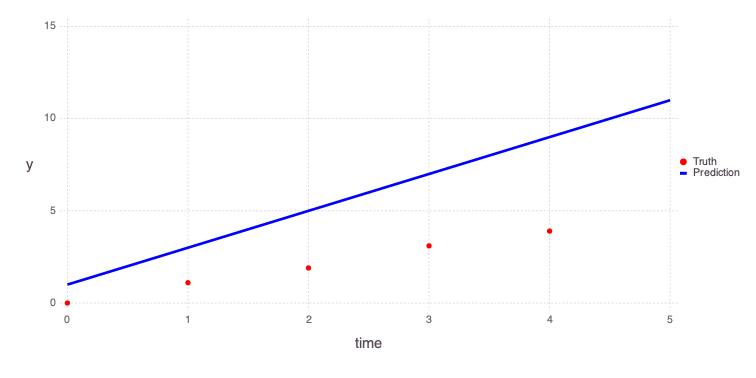

In [15]:
Mads.plotmatches(md)

The figure above shows that the `true` observations are not well reproduced by the model using the initial model parameter guesses.

## Model calibration (inversion)

The calibation (inversion) of the developed model is achieved using the following command:

In [16]:
calib_param, calib_result = Mads.calibrate(md)

(OrderedCollections.OrderedDict("a" => 0.48652749043975874, "b" => 0.48653799120462793, "c" => -0.001625793681175658, "n" => 1.0209744172380697), OptimBase.MultivariateOptimizationResults{LsqFit.LevenbergMarquardt, Float64, 1}(LsqFit.LevenbergMarquardt(), [0.10016742116155988, 0.10016742116155988, 0.20135792079033074, 0.33983690945412187], [0.04867196375755519, 0.04867301507909251, -0.00032515874196489825, 0.3472623008114141], 420.3001214282925, 5, false, true, 0.0001, 0.0, false, 0.001, 0.0, false, 1.0e-6, 0.0, false, Iter     Function value   Gradient norm 
------   --------------   --------------
, 71, 5, 0))

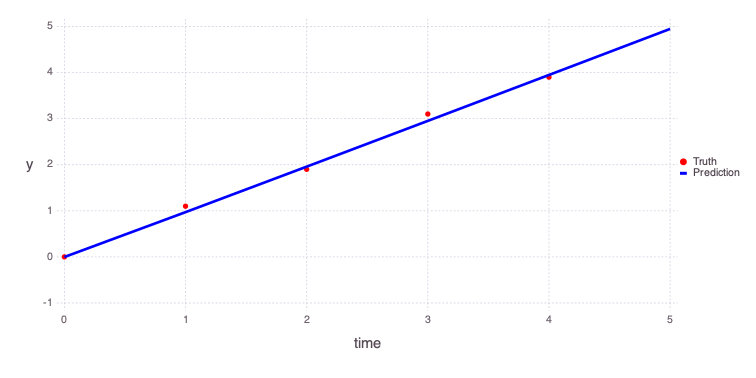

In [17]:
Mads.plotmatches(md, calib_param)

Initial values of the model parameters are:

In [38]:
Mads.showparameterestimates(md)

a =               1 distribution = Uniform(-10, 10) 
b =               1 distribution = Uniform(-10, 10) 
c =               1 distribution = Uniform(-5, 5) 
n =               1 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


Estimated values of the model parameters based on the model calibration (inversion) are:

In [39]:
Mads.showparameterestimates(md, calib_param)

a =        0.486527 distribution = Uniform(-10, 10) 
b =        0.486538 distribution = Uniform(-10, 10) 
c =     -0.00162579 distribution = Uniform(-5, 5) 
n =         1.02097 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


The model inversion can be also performed for a set of random initial guesses for model parameters.

In [40]:
calib_random_results = Mads.calibraterandom(md, 100; seed=2021, all=true)

100×3 Matrix{Any}:
  232.272  …  OrderedCollections.OrderedDict("a"=>0.00653517, "b"=>0.950689, "c"=>0.039249, "n"=>3.0)
  270.314     OrderedCollections.OrderedDict("a"=>-0.28542, "b"=>1.27948, "c"=>0.0178456, "n"=>0.951994)
  232.272     OrderedCollections.OrderedDict("a"=>0.00653398, "b"=>0.950704, "c"=>0.0392286, "n"=>3.0)
  232.272     OrderedCollections.OrderedDict("a"=>0.00653436, "b"=>0.950702, "c"=>0.0392321, "n"=>2.99998)
  232.272     OrderedCollections.OrderedDict("a"=>0.00653522, "b"=>0.950689, "c"=>0.039249, "n"=>3.0)
  270.097  …  OrderedCollections.OrderedDict("a"=>-4.30065, "b"=>5.28695, "c"=>0.0214167, "n"=>0.995285)
 7643.02      OrderedCollections.OrderedDict("a"=>-9.89624, "b"=>9.82224, "c"=>0.622939, "n"=>0.910639)
  269.91      OrderedCollections.OrderedDict("a"=>-4.41759, "b"=>5.40692, "c"=>0.0206894, "n"=>0.9961)
  270.093     OrderedCollections.OrderedDict("a"=>-4.82082, "b"=>5.80708, "c"=>0.0214349, "n"=>0.995788)
  270.067     OrderedCollections.OrderedDict(

Collect the parameter estimates from the 100 random-initial-guess inverse runs executed below:

In [42]:
calib_random_estimates = hcat(map(i->collect(values(calib_random_results[i,3])), 1:100)...)

4×100 Matrix{Float64}:
 0.00653517  -0.28542    0.00653398  …  0.962624   -5.46149    -0.387051
 0.950689     1.27948    0.950704       0.0219806   6.44768     1.37691
 0.039249     0.0178456  0.0392286      0.0223074   0.0214512   0.0197667
 3.0          0.951994   3.0            1.02225     0.996277    0.954846

Plot the final predictions of the 100 random-initial-guess inverse runs:

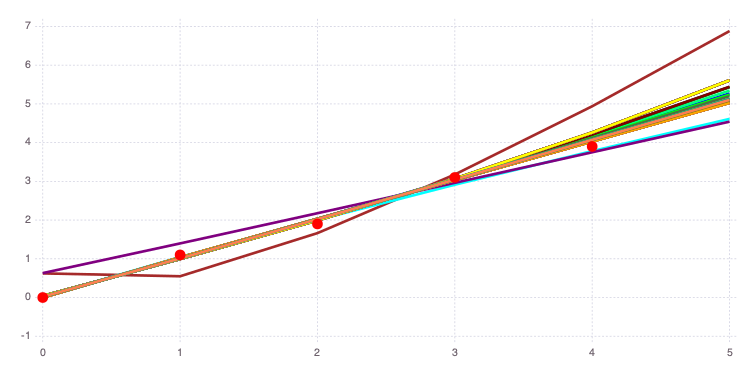

In [43]:
forward_predictions = Mads.forward(md, calib_random_estimates)
Mads.spaghettiplot(md, forward_predictions)

The figure above demonstrates that there are several different global minima.

There are three important cases with different values for n:
* n = 0
* n = 1
* n = 3 (upper prior bound)

The code below finds and plots solutions associated with these 3 distinct cases:

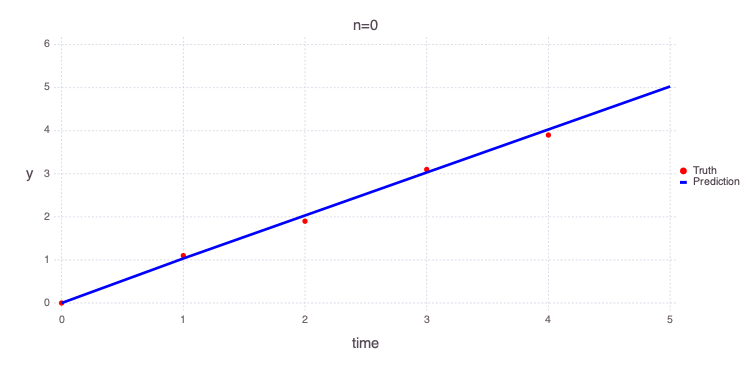

Solution for n=0
a =       0.0354613 distribution = Uniform(-10, 10) 
b =        0.998702 distribution = Uniform(-10, 10) 
c =     1.70238e-05 distribution = Uniform(-5, 5) 
n =     0.000376271 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


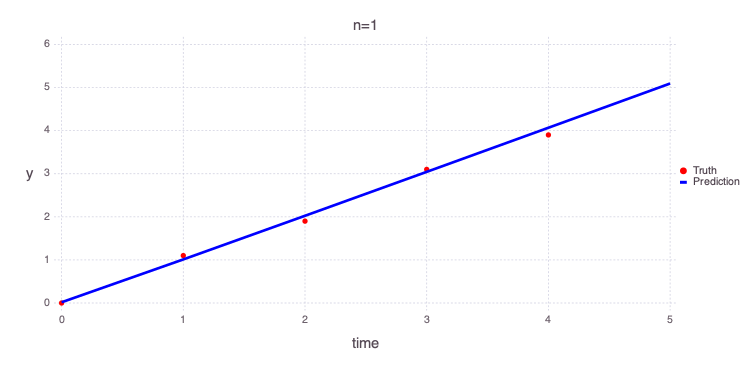

Solution for n=1
a =        -0.28542 distribution = Uniform(-10, 10) 
b =         1.27948 distribution = Uniform(-10, 10) 
c =       0.0178456 distribution = Uniform(-5, 5) 
n =        0.951994 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


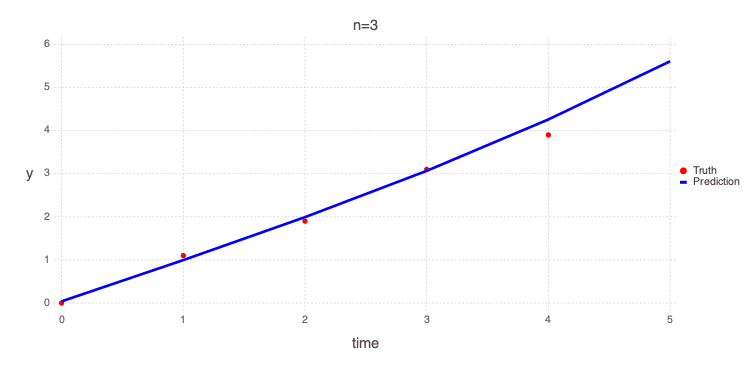

Solution for n=3
a =      0.00653517 distribution = Uniform(-10, 10) 
b =        0.950689 distribution = Uniform(-10, 10) 
c =        0.039249 distribution = Uniform(-5, 5) 
n =               3 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


In [47]:
ind_n0 = abs.(calib_random_estimates[4,:]) .< 0.1
in0 = findall(ind_n0 .== true)[1]
ind_n1 = abs.(calib_random_estimates[4,:] .- 1) .< 0.1
in1 = findall(ind_n1 .== true)[1]
ind_n3 = .!(ind_n0 .| ind_n1)
in3 = findall(ind_n3 .== true)[1]
pinit = Dict(zip(Mads.getparamkeys(md), Mads.getparamsinit(md)))
optnames = ["n=0", "n=1", "n=3"]
v = [in0, in1, in3]

for i = 1:3
	println("Solution for $(optnames[i])")
	Mads.showparameters(md, calib_random_results[v[i],3])
	Mads.plotmatches(md, calib_random_results[v[i],3]; title=optnames[i])
end

## Evaluation of predictive sensitivities and uncertainties

### Local sensitivity and uncertainty quantification

In [20]:
localsa = Mads.localsa(md; filename="model_diagnostics.png", par=collect(values(calib_param)))

Dict{String, Any} with 6 entries:
  "of"          => 420.3
  "jacobian"    => [0.0 0.0 499.175 0.0; 994.721 994.721 499.175 0.0; … ; 409.6…
  "covar"       => [0.525233 -0.525787 0.000235488 -0.0662933; -0.525787 0.5263…
  "eigenmatrix" => [0.702251 0.102386 0.0288238 0.703939; 0.688973 0.0768143 0.…
  "eigenvalues" => [3.38862e-8, 2.743e-6, 3.91435e-5, 1.05994]
  "stddev"      => [0.72473, 0.725495, 0.00200318, 0.0916738]

`localsa["stddev"]` defines the estimated posterior uncertainties in the estimated model parameters.
This estimate is based on the Jacobian / Hessian matrix estiamtes of the parameter space curvature in the area of the estimated (inverted) optimal parameters.
The uncertaintties are assumed to Gaussian with standard deviations defined by `localsa["stddev"]`.

In [49]:
[Mads.getparamlabels(md) localsa["stddev"]]

4×2 Matrix{Any}:
 "a"  0.72473
 "b"  0.725495
 "c"  0.00200318
 "n"  0.0916738

Based on these results, `c` is well contraiend. `n` is also well defimed. `a` and `b` are the most uncertain.

Howver, because of the local nature of the estimates these results are not very accurate and differ with the global  sensitivity and uncertainty analyses presented below.



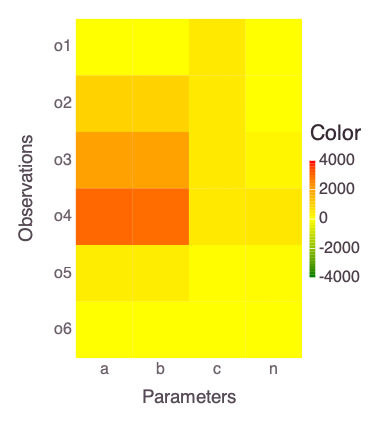

In [53]:
Mads.display("model_diagnostics-jacobian.png")

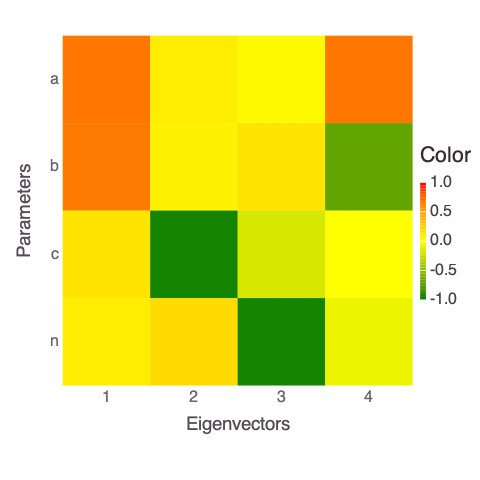

In [51]:
Mads.display("model_diagnostics-eigenmatrix.png")

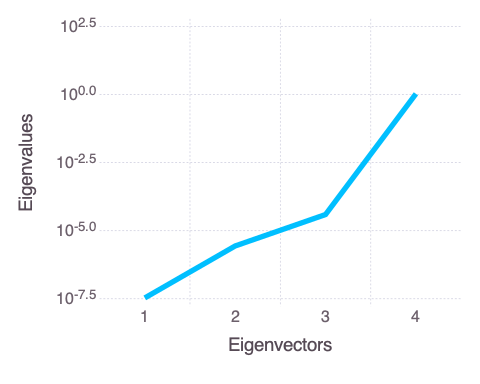

In [52]:
Mads.display("model_diagnostics-eigenvalues.png")

## Global sensitivity and uncertainty quantification

### Affine Invariant MCMC

In [22]:
chain, llhoods = Mads.emceesampling(md; numwalkers=10, nsteps=100000, burnin=10000, thinning=10, seed=2016, sigma=0.01)

([-2.9318734488241254 -2.2115004894325656 … 0.59046225841824 -0.1317764013305327; 3.9213382339060123 3.2754768843563364 … 0.4001283063148645 1.0610138945109913; 0.025000166709641274 -0.07072908085654725 … 0.062343770966873546 0.07827331041888207; 0.9914349083311713 1.0146213546858134 … 1.009450999917408 0.20217807527536452], [-13.350385897100534, -13.83572977185207, -14.62374978746418, -13.542296325761239, -13.743265533105149, -13.371356376807029, -15.437727968793991, -13.923819788102527, -14.03616530179732, -17.012966126679196  …  -14.999244279386676, -14.832192904405328, -14.205686001261679, -13.51735973205491, -13.177385309063698, -13.374322254910798, -15.70916729088129, -13.311448472159798, -13.452308243225435, -14.380811745476537])

In [23]:
f = Mads.forward(md, chain)

6×10000 Matrix{Float64}:
 0.0250002  -0.0707291  0.0462104  …  0.0135752  0.0623438  0.0782733
 1.01446     0.993247   0.931065      1.00549    1.05293    1.00751
 2.03864     2.01217    1.9508        1.99482    2.05129    2.0487
 3.07577     3.01377    3.00617       2.98318    3.0526     3.09676
 4.12129     4.00404    4.08221       3.97092    4.05585    4.14792
 5.17302     4.98586    5.17251    …  4.9582     5.06055    5.20089

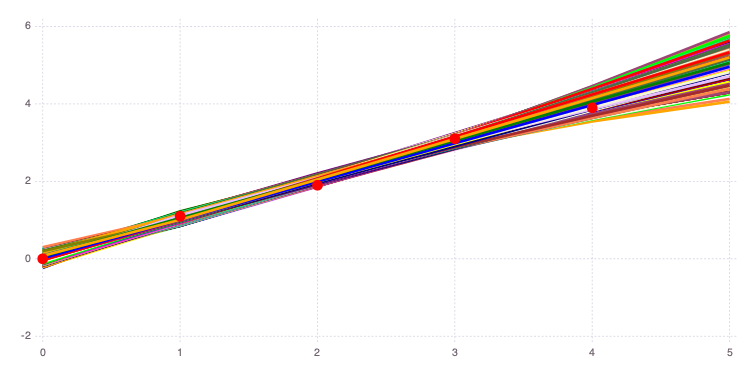

In [24]:
Mads.spaghettiplot(md, f)

In [25]:
Mads.scatterplotsamples(md, permutedims(chain), "model_diagnostics-emcee_scatter.png")

┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1317


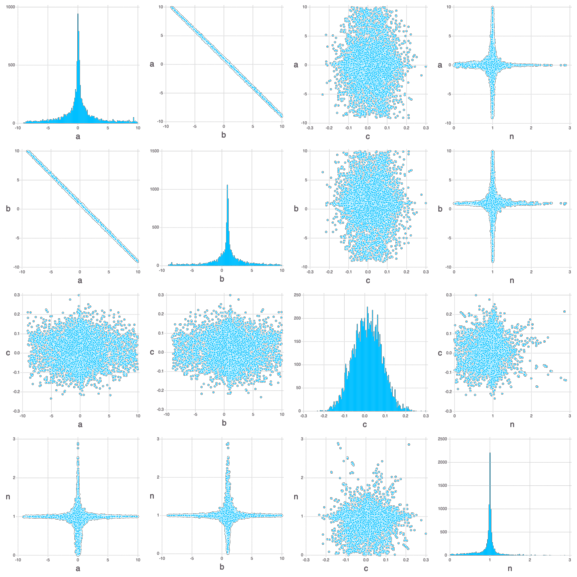

In [26]:
Mads.display("model_diagnostics-emcee_scatter.png")